# **Neural Style transfer with pre-trained VGG19 model**


Neural style transfer is the technique to compose images or videos in the style of another image (for e.g. a famous artwork) using deep learning networks.Neural style transfer is based on the idea that it is possible to separate the style representation and content representations in a CNN, learnt during a computer vision task (e.g. image recognition task).


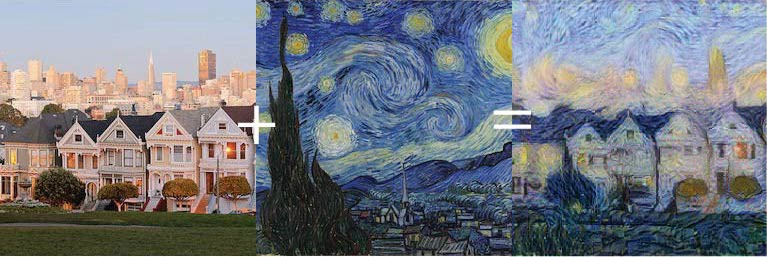

As seen, the generated image is having the content of the content image and style of the style image.

**Note** - why VGG model and not any other deep CNN ?
Primarily since the authors in the original paper suggested using VGG architecture for obtaining the best results and secondly as I learnt after doing some research online,it seems that due to the complexity of architecture of other very deep CNNs(like Resnet), the feature maps do not work give as optimal results as well as those of VGG16 or VGG19 .


# **Importing necessary libraries**

In [1]:
import numpy as np 
import time 
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display

import tensorflow as tf
import keras.preprocessing.image as process_im
from keras.applications import vgg19
from tensorflow.python.keras import models 

2023-07-11 13:36:24.222799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:36:24.271706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:36:24.272404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 13:36:25.018749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Define function to load images and return numpy array**

In [2]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                               #batch of single image 
    
    return im_array

**Define function to plot image**

In [3]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

**Define function to process image for input to vgg19 model**

In [4]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

**Define function to deprocess image **

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [5]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
    
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [6]:
#im=img_preprocess(content_path)

**Get necessary layers from vgg19 model**

In [7]:
content_layers = ['block3_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get vgg19 model with pretrained weights**

In [8]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [9]:
#Show Full Model
if False:
    model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    model.summary()

In [10]:
#Show Model with only layers up to highest layer in style/content
if False:
    model=get_model()
    model.summary()

# **Loss Functions**

Neural style transfer is done by defining two loss functions that try to minimise the differences between a content image, a style image and a generated image. Take the base input image, the content image and the style image that needs to be matched and transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image.

The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image. 

**Define content loss**

Essentially content loss captures the root mean squared error between the activations produced by the generated image and the content image.

In [11]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

**Define style loss**


The goal is to compute a style matrix for the generated image and the style image. Then the style loss is defined as the root mean square difference between the two style matrices. Style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. The gram matrix is used to find the correlation between the feature maps of a convolution layer.

In [12]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])                             #(height, width, channels) is made to (a, channels)
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [13]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [14]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

**Define function to compute total loss**

In [15]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weights,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    #Init Style_weights so they total 1 million
    global init_style_weights
    global style_layer_weight

    if init_style_weights:
        init_style_weights=False
        style_layer_weight=[]
        layer=0
        for a,b in zip(gram_style_features,noise_style_features):
            style_layer_weight.append(style_weights[layer]/get_style_loss(b[0],a))
            layer+=1
            
    layer=0
    for a,b in zip(gram_style_features,noise_style_features):
        layer_loss = style_layer_weight[layer]*get_style_loss(b[0],a)
        print(layer_loss)
        style_loss += layer_loss
        layer+=1
        
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)        

    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

**Define function to calculate gradient**

In [16]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [17]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

2023-07-11 13:36:41.645782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-07-11 13:36:41.645838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: bot
2023-07-11 13:36:41.645849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: bot
2023-07-11 13:36:41.646045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-07-11 13:36:41.646073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.41.3
2023-07-11 13:36:41.646082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 530.41.3 does not match DSO version 535.54.3 -- cannot find working devices in this configuration


In [18]:
def run_style_transfer(content_path,style_path,style_weights,epochs=500,content_weight=1000):
    model=get_model()
    global init_style_weights
    global style_layer_weight
    init_style_weights=True
    style_layer_weight=0
    
    for layer in model.layers:
        layer.trainable = False
    
    #Gram_matrix for style is created only once in the beginning
    content_feature,style_feature = get_features(model,content_path,style_path)         #get content and style features from both input images
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]               #precalculate Gram Matrix for style image                                    
    #Image is initialized with content image
    noise = img_preprocess(content_path)                                    
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=10e-8)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weights, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    
    imgs = []
    when_plot=1
    
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)                                        #Gram_matrix called
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
        #for visualization and saving
        
        if i%when_plot==0 or i == epochs-1:
            if i==4:
                when_plot=2
            if i==16:
                when_plot=4
            if i==64:
                when_plot=8
            if i==256:
                when_plot=16
            if i==1024:
                when_plot=32
            
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            if i!=epochs-1:
                IPython.display.clear_output(wait=True)
                IPython.display.display_png(Image.fromarray(plot_img))
                print('Epoch: {}'.format(i))        
                print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
            
            img = Image.fromarray(plot_img, 'RGB')
            location = "Video/"+str(i)+".jpg"
            img.save(location)
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

# **Style Transfer Visualization**

    Rule of thumb: 
    If transfer is too extreme increase content weight and maybe pick lower content layer
    the later the last layer of content OR style, the more slow the 
    often the last picture is not the best but an intermediate
   
Division instead of subtraction for loss does not work well, probably because the higher values tend to be the most important ones for style and there are many less necessary things that are represented in the net!
    

In [19]:
content_path='Video/Target/Harbor_Village.jpg'
style_path = 'Video/Style/great_wave.jpg'

In [20]:
#redundant definition of layers for no-scroll
content_layers = ['block2_conv2']
style_layers = ['block1_conv1',                                          #Low level features
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block4_conv1', 
                'block4_conv2',
                'block5_conv1'                                  #High level features
               ]
style_weights = [5000,                                          #Low level features
                5000,
                7500, 
                10000, 
                17500,                                            #High level features
                17500,                                          #Low level features
                10000,
                12500, 
                15000, 
               ]

number_content=len(content_layers)
number_style =len(style_layers)

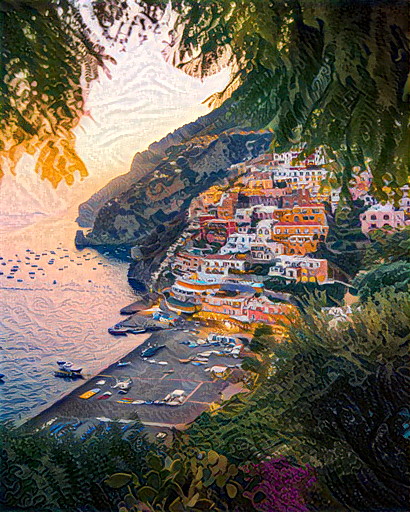

Epoch: 6
Total loss: 5.1504e+04, style loss: 4.6466e+04, content loss: 5.0375e+03, 


KeyboardInterrupt: 

In [21]:
t1=time.time()
best, best_loss,image = run_style_transfer(content_path, style_path, style_weights, epochs=500, content_weight=0.2)
t2=time.time()
#print(t2-t1)

    20: ballet+water   
    b1-b5 & b3,2:   67.93
    b1-b4 & b3,2:   55.33
    b1 & b3,2:      40.0725793838501
    b1-b2 & b2,1:   28.96
    b1 & b2,1:      27.77
    b1 & b1,2:      20.03
    b1 & b1,1:      9.272374868392944    
    b1-b3 & b1,2:   42.41
    b5 & b1,2:      68.67
    b5 & b3,2:      65.54

Just highest layer is relevant for time!

In [ ]:
content = load_file(content_path)
style = load_file(style_path)
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

#redundant definition of layers for no-scroll
content_layers = ['block3_conv2']
style_layers = ['block1_conv1',                                          #Low level features
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block4_conv1', 
                'block4_conv2',
                'block5_conv1'                                  #High level features
               ]
style_weights = [5000,                                          #Low level features
                5000,
                7500, 
                10000, 
                17500,                                            #High level features
                17500,                                          #Low level features
                10000,
                12500, 
                15000, 
               ]

number_content=len(content_layers)
number_style =len(style_layers)